### 1. Clean Parquet data from Kaggle (integer dtypes parquet)
- This notebook aims to further clean the data taken from Kaggle's user, without affecting data quality

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import matplotlib.pyplot as plt
import gc
import numpy as np
import os
import sys
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS, ROUND_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.constants import (
    PROCESSED_DATA_PATH
)

In [4]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"

In [5]:
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [6]:
%load_ext autoreload
%autoreload

### Read Data

In [7]:
%%time
train = read_file(f"{RAW_TRAIN_PARQUET_PATH}/train.parquet", replace_negative_one=False)
test = read_file(f"{RAW_TEST_PARQUET_PATH}/test.parquet", replace_negative_one=False)

Shape of data: (5531451, 190)
Shape of data: (11363762, 190)
CPU times: user 9.87 s, sys: 10.9 s, total: 20.8 s
Wall time: 9.34 s


In [8]:
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")

In [9]:
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

### B_8

In [20]:
%%time
train["B_8"] = train["B_8"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)
test["B_8"] = test["B_8"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)

CPU times: user 3.97 s, sys: 2.1 s, total: 6.07 s
Wall time: 6.64 s


In [21]:
# plot_train_test_distribution(train, test, col="B_8")

0 null count, 0.000 null proportion
nan of the targets have label = 1


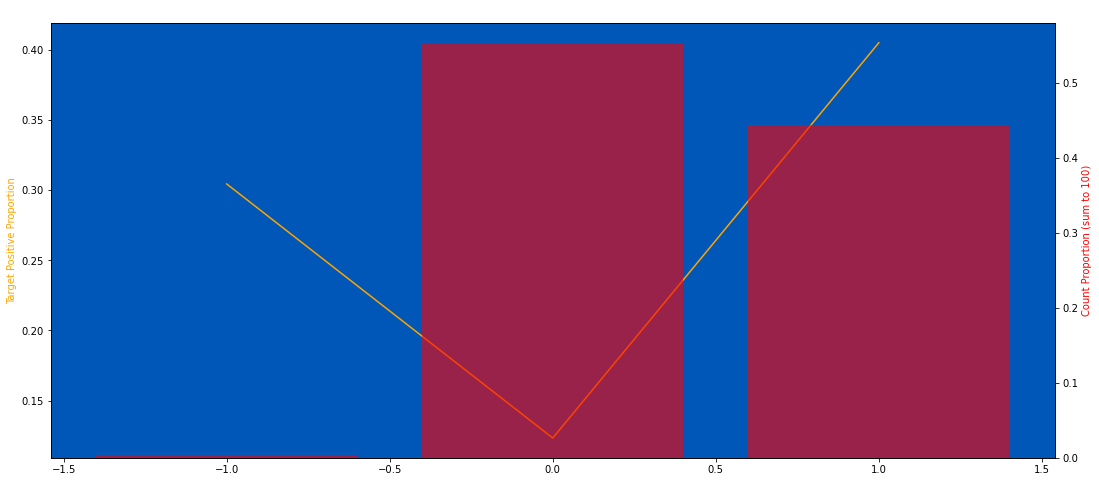

In [22]:
plot_target_check(train, "B_8")

### B_36

In [23]:
# plot_train_test_distribution(train, test, col="B_36")

- Most of the B_36 is just 0, round them to the nearest integer (it should be either 0 or 1)

In [24]:
%%time
train["B_36"] = train["B_36"].apply(lambda x: 1 if x >= 0.01 else 0).astype(np.int8)
test["B_36"] = test["B_36"].apply(lambda x: 1 if x >= 0.01 else 0).astype(np.int8)

CPU times: user 3.24 s, sys: 1.71 s, total: 4.95 s
Wall time: 5.32 s


In [25]:
# plot_train_test_distribution(train, test, col="B_36")

0 null count, 0.000 null proportion
nan of the targets have label = 1


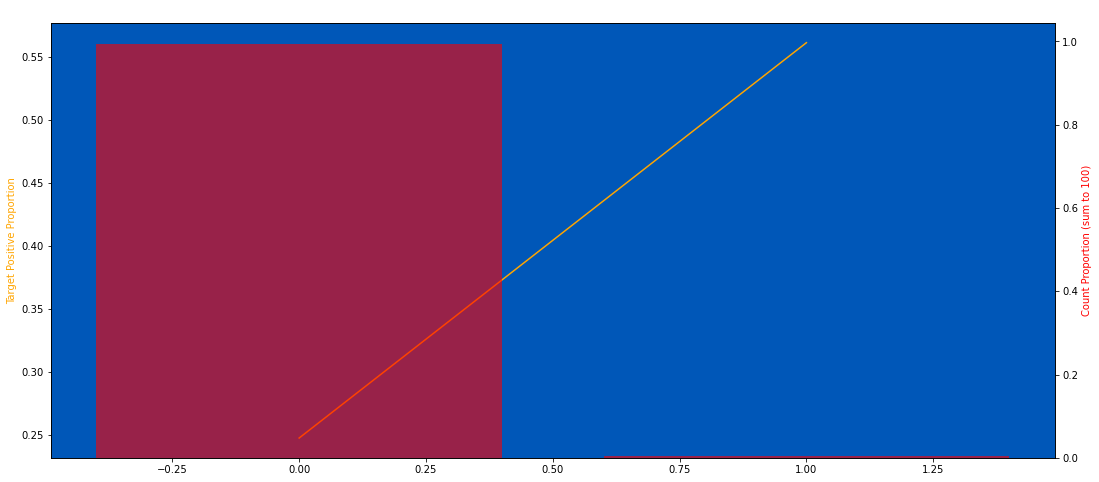

In [26]:
plot_target_check(train, "B_36")

### D_54

In [27]:
# plot_train_test_distribution(train, test, col="D_54")

- Most of the D_54 is just 1 (some are 0), round them to the nearest integer (it should be again either 0 or 1)

In [28]:
%%time
train["D_54"] = train["D_54"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)
test["D_54"] = test["D_54"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)

CPU times: user 3.92 s, sys: 1.65 s, total: 5.58 s
Wall time: 6.01 s


In [29]:
# plot_train_test_distribution(train, test, col="D_54")

0 null count, 0.000 null proportion
nan of the targets have label = 1


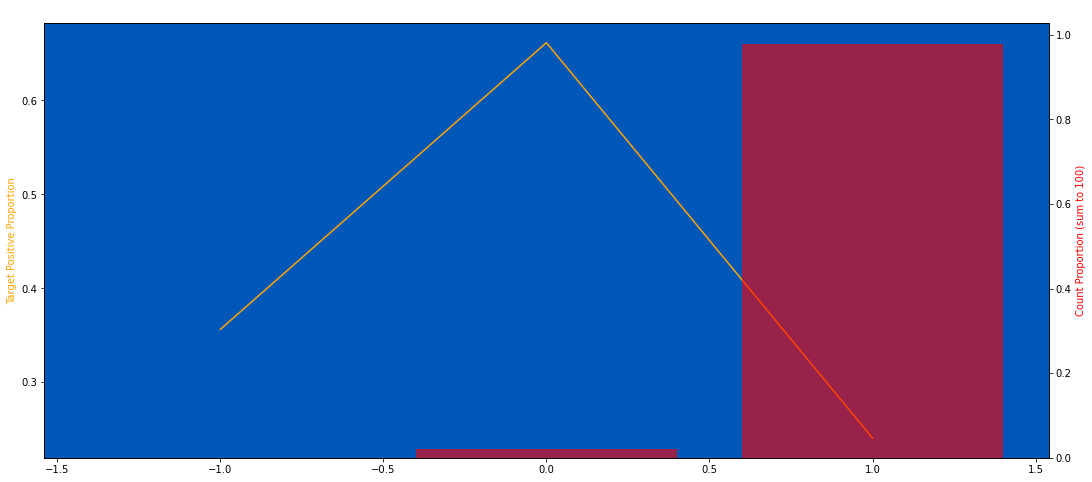

In [30]:
plot_target_check(train, "D_54")

In [31]:
check_overlap_missing(train, "D_54", "D_59", n1=-1, n2=-1)

D_54 missing count 2016
D_59 missing count 106725
Both D_54 & D_59 missing count 2016


In [32]:
train.loc[train["D_59"] != -1, ["D_54", "D_59"]].corr()

,D_54,D_59
D_54,1.0000,-0.0461
D_59,-0.0461,1.0000


- Although all records with missing entries in D_54 also have missing values in D_59, their values are not correlated actually

### D_60

In [33]:
# plot_train_test_distribution(train, test, col="D_60")

In [34]:
train.loc[train["D_60"].between(0, 0.01), "D_60"] = 0
test.loc[test["D_60"].between(0, 0.01), "D_60"] = 0

In [35]:
train.loc[train["D_60"].between(1, 1.1), "D_60"] = 1
test.loc[test["D_60"].between(1, 1.1), "D_60"] = 1

In [36]:
# plot_train_test_distribution(train, test, col="D_60")

0 null count, 0.000 null proportion
nan of the targets have label = 1


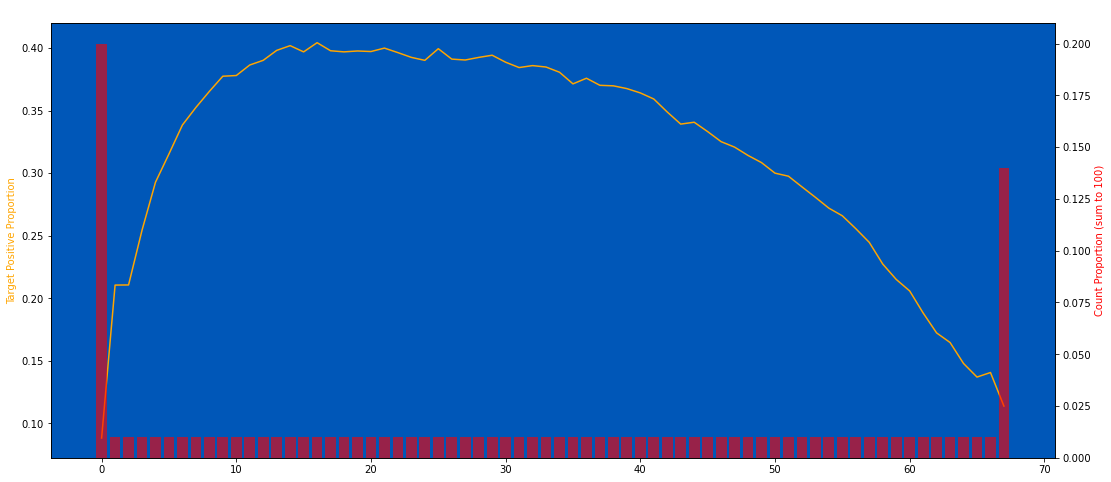

In [37]:
plot_target_check(train, "D_60", q=100)

### D_64

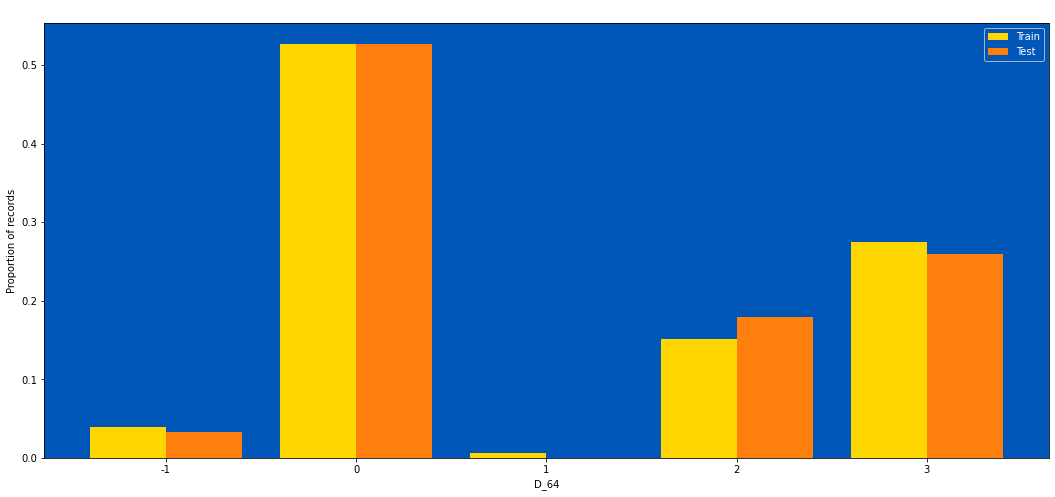

In [12]:
plot_train_test_distribution(train, test, col="D_64")

- D_64 has one additional category (1) in training set which is not in test set

0 null count, 0.000 null proportion
nan of the targets have label = 1


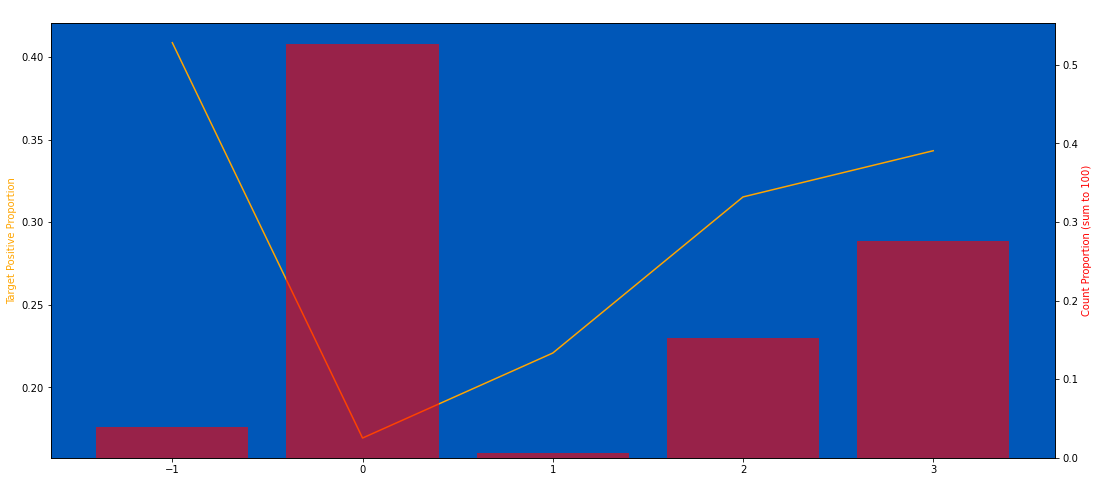

In [13]:
plot_target_check(train, "D_64")

- Category 1 has different target distribution with other categories, can't merge and remove category 1
- The higher the D_64, the higher the average default rate;
- Records with missing D_64 has the highest chance of being default (about 40%), set category -1 (NaN) as category 4

In [14]:
%%time
train["D_64"] = train["D_64"].replace(-1, 4).astype(np.int8)
test["D_64"] = test["D_64"].replace(-1, 4).astype(np.int8)

CPU times: user 369 ms, sys: 99.5 ms, total: 469 ms
Wall time: 158 ms


0 null count, 0.000 null proportion
nan of the targets have label = 1


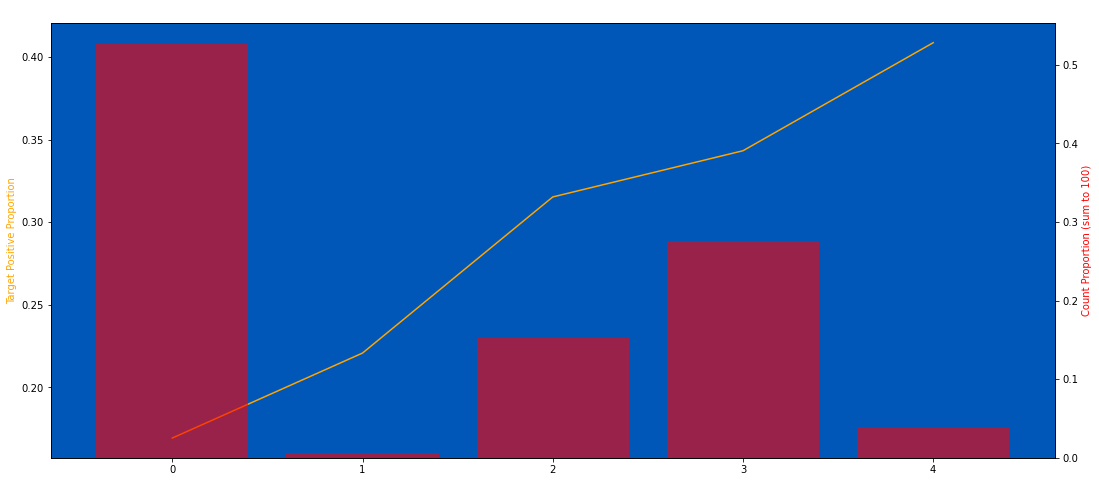

In [15]:
plot_target_check(train, "D_64")

### D_68

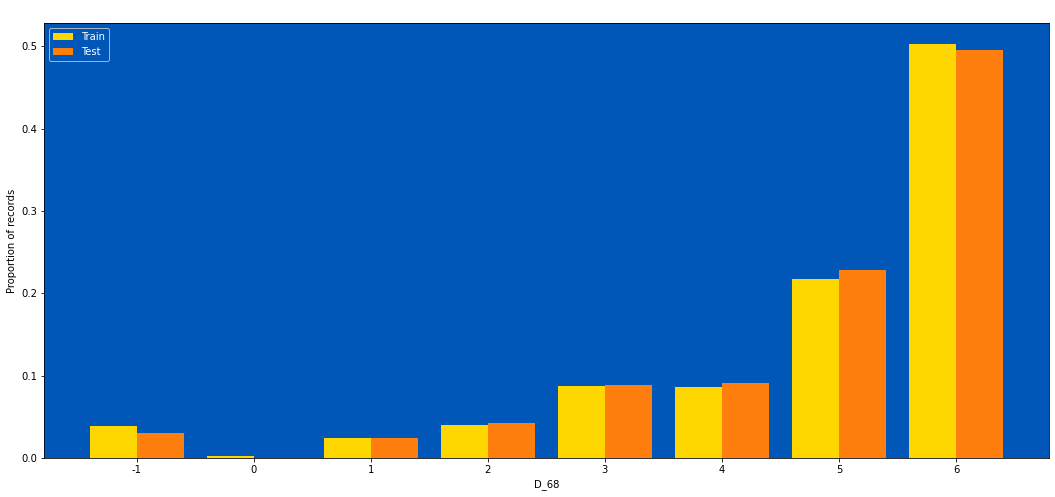

In [16]:
plot_train_test_distribution(train, test, col="D_68")

- D_68 has one additional category (0) in training set which is not in test set

0 null count, 0.000 null proportion
nan of the targets have label = 1


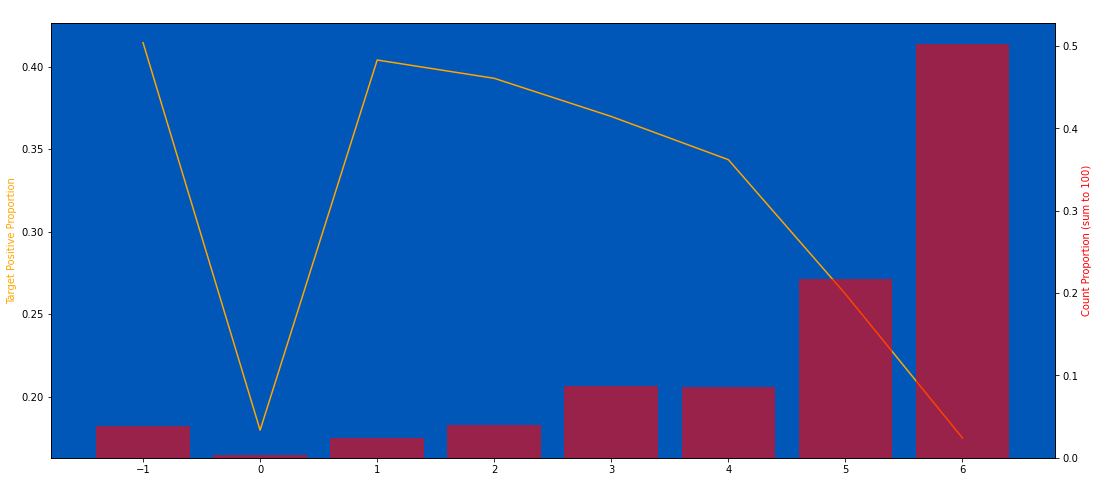

In [17]:
plot_target_check(train, "D_68")

- Category 0 has similar target distribution as category 6, merge it into category 6
- Then, set category -1 (NaN) into 0 since the default rate is the highest if D_68 is missing

In [18]:
%%time
train["D_68"] = train["D_68"].replace(0, 6).replace(-1, 0).astype(np.int8)
test["D_68"] = test["D_68"].replace(0, 6).replace(-1, 0).astype(np.int8)

CPU times: user 401 ms, sys: 100 ms, total: 501 ms
Wall time: 171 ms


0 null count, 0.000 null proportion
nan of the targets have label = 1


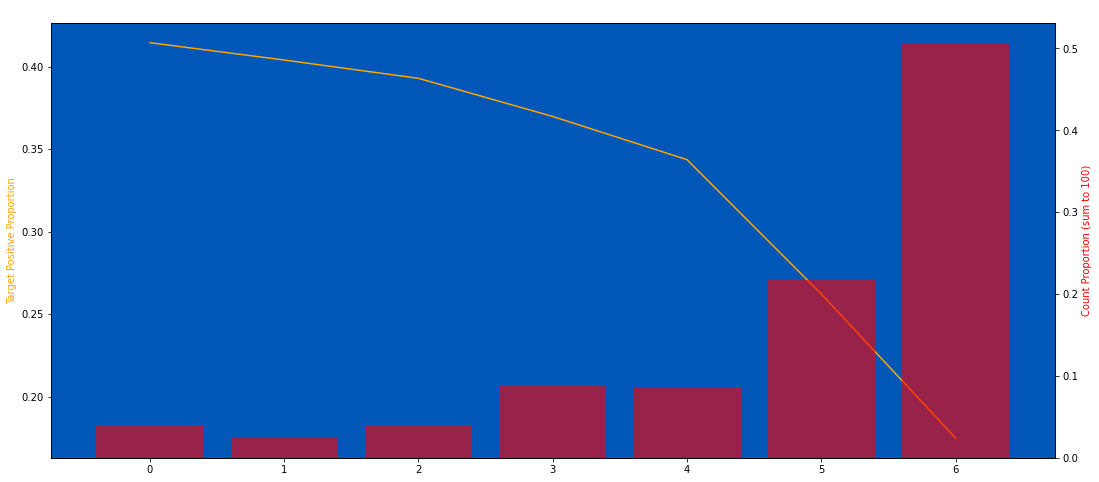

In [19]:
plot_target_check(train, "D_68")

### D_104

In [38]:
# plot_train_test_distribution(train, test, col="D_104")

In [39]:
train.loc[train["D_104"].between(0.99, 1.01), "D_104"] = 1
test.loc[test["D_104"].between(0.99, 1.01), "D_104"] = 1

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1


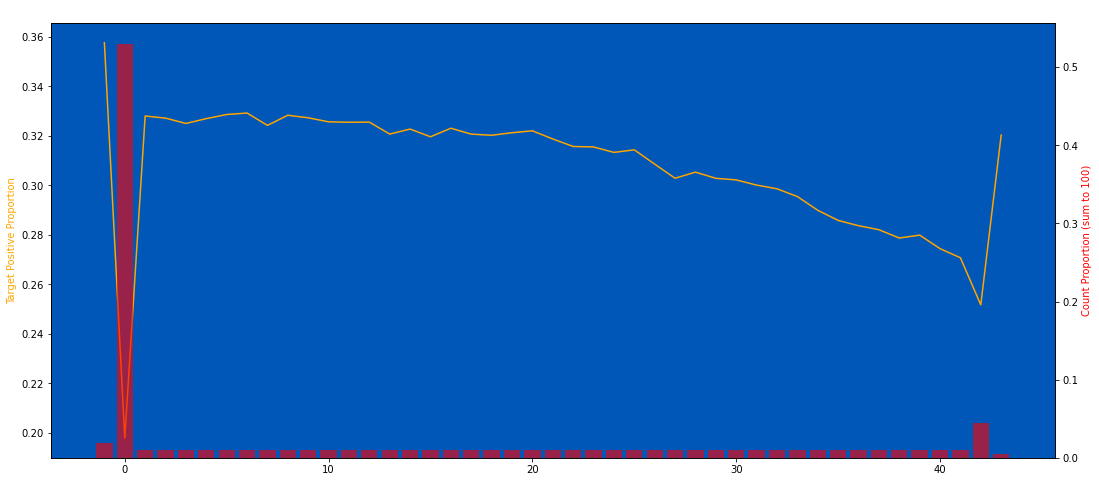

In [40]:
plot_target_check(train, "D_104", q=100)

### D_128

In [41]:
# plot_train_test_distribution(train, test, col="D_128")

In [42]:
%%time
train["D_128"] = train["D_128"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)
test["D_128"] = test["D_128"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)

CPU times: user 3.89 s, sys: 1.44 s, total: 5.34 s
Wall time: 5.79 s


In [43]:
# plot_train_test_distribution(train, test, col="D_128")

0 null count, 0.000 null proportion
nan of the targets have label = 1


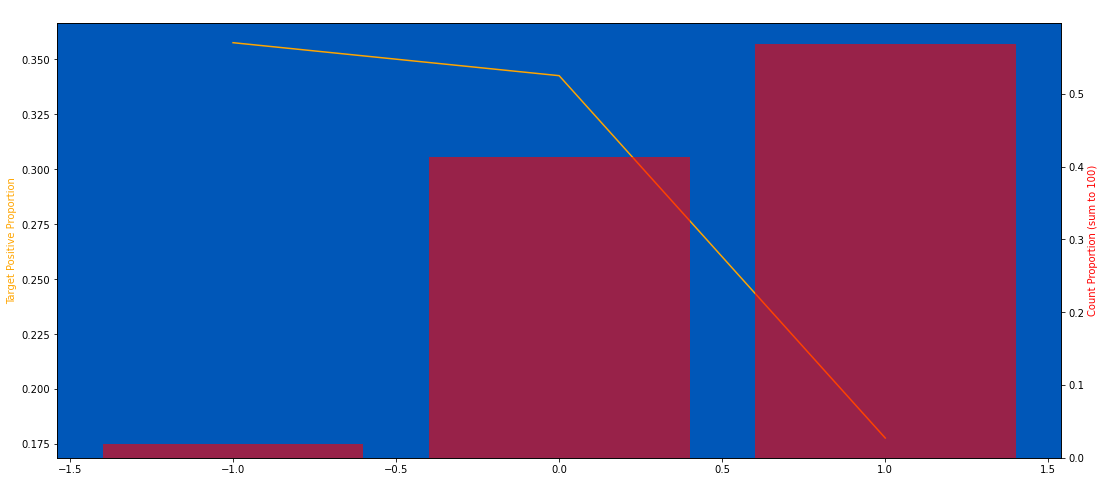

In [44]:
plot_target_check(train, "D_128")

### D_130

In [45]:
column = "D_130"

In [46]:
# plot_train_test_distribution(train, test, col="D_130")

In [47]:
%%time
train["D_130"] = train["D_130"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)
test["D_130"] = test["D_130"].apply(lambda x: round(x) if x == x else x).replace(np.nan, -1).astype(np.int8)

CPU times: user 3.92 s, sys: 1.65 s, total: 5.57 s
Wall time: 5.95 s


In [48]:
# plot_train_test_distribution(train, test, col="D_130")

0 null count, 0.000 null proportion
nan of the targets have label = 1


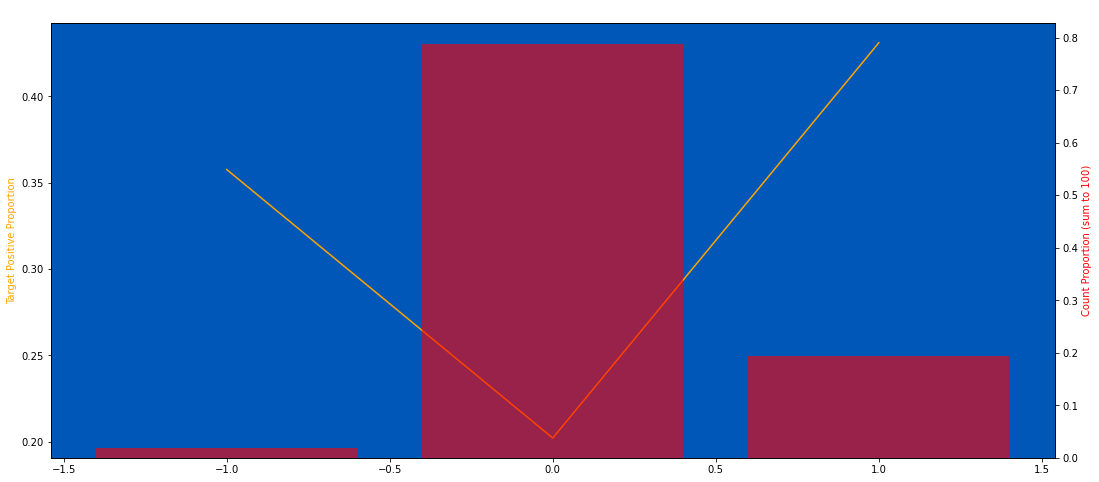

In [49]:
plot_target_check(train, "D_130")

### R_1

In [50]:
# plot_train_test_distribution(train, test, col="R_1")

In [51]:
%%time
train["R_1"] = (train["R_1"] * 4).astype(np.int8)
test["R_1"] = (test["R_1"] * 4).astype(np.int8)

CPU times: user 654 ms, sys: 1.54 s, total: 2.2 s
Wall time: 2.52 s


In [52]:
# plot_train_test_distribution(train, test, col="R_1")

0 null count, 0.000 null proportion
nan of the targets have label = 1


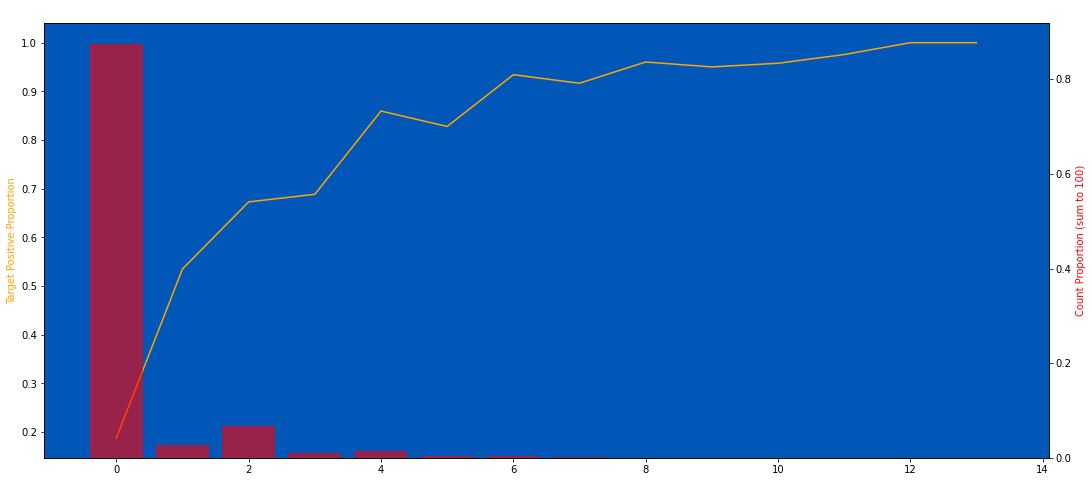

In [53]:
plot_target_check(train, "R_1")

### S_19

In [54]:
# plot_train_test_distribution(train, test, col="S_19")

In [55]:
%%time
train["S_19"] = train["S_19"].apply(lambda x: 1 if x >= 0.01 else 0).astype(np.int8)
test["S_19"] = test["S_19"].apply(lambda x: 1 if x >= 0.01 else 0).astype(np.int8)

CPU times: user 3.23 s, sys: 1.63 s, total: 4.86 s
Wall time: 5.21 s


In [56]:
# plot_train_test_distribution(train, test, col="S_19")

0 null count, 0.000 null proportion
nan of the targets have label = 1


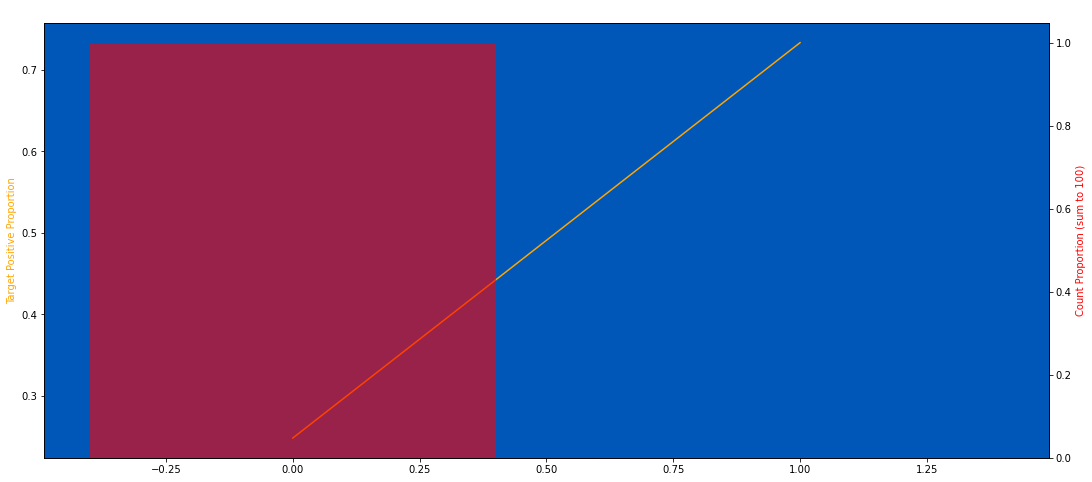

In [57]:
plot_target_check(train, "S_19")

In [58]:
gc.collect()

12621

### S_23

In [61]:
# plot_train_test_distribution(train, test, col="S_23")

In [71]:
train.loc[train["S_23"].between(0.13, 0.141), "S_23"] = 0.135
test.loc[test["S_23"].between(0.13, 0.141), "S_23"] = 0.135

In [77]:
train["S_23"].describe()

count   5,531,006.0000
mean            0.1729
std             0.8509
min          -206.0855
25%             0.1350
50%             0.1350
75%             0.1350
max           885.3349
Name: S_23, dtype: float64

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


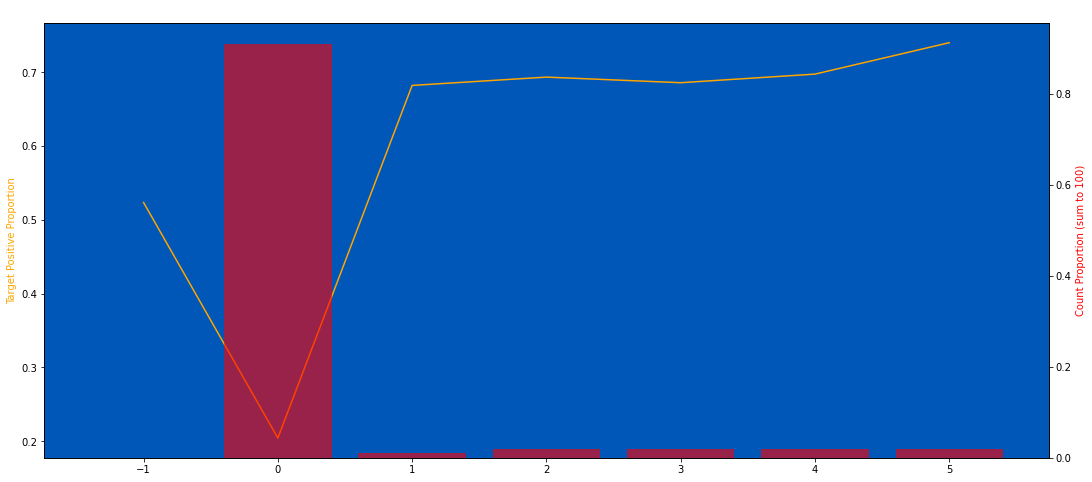

In [81]:
plot_target_check(train, "S_23", q=50)

### Insert row_number

In [82]:
%%time
insert_row_number(train)
insert_row_number(test)

Done insertion
Done insertion
CPU times: user 36.4 s, sys: 539 ms, total: 36.9 s
Wall time: 37 s


In [83]:
train = train.drop(columns="temp", errors="ignore")
test = test.drop(columns="temp", errors="ignore")

In [84]:
train.shape, test.shape

((5531451, 193), (11363762, 192))

### Export data out

In [85]:
%%time
train.to_pickle(f"{RAW_TRAIN_PICKLE_PATH}/raw_train_data.pkl")
test.to_pickle(f"{RAW_TEST_PICKLE_PATH}/raw_test_data.pkl")

CPU times: user 870 ms, sys: 2.76 s, total: 3.63 s
Wall time: 5.22 s
